In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string


#ML
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

#for execution time
import time


In [2]:
df = pd.read_csv('../Data/lotr/prepped_data.csv',dtype=str)

In [3]:
top10_chars = ['FRODO','SAM','GANDALF','ARAGORN','PIPPIN','MERRY','GOLLUM','GIMLI','THEODEN','FARAMIR']

In [5]:
def best_model_stats(model,X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    labels = model.predict(X_test)
    
    mat = confusion_matrix(y_test.values.argmax(axis=1), labels.argmax(axis=1))


    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=y_train.columns.to_list(), yticklabels=y_train.columns.to_list())

    plt.xlabel('true label')
    plt.ylabel('predicted label')    
    plt.show()
    print('Accuracy score:', accuracy_score(y_test, labels))

    print("Execution time: %s seconds " % (time.time() - start_time))
    
    
    

In [6]:
def get_best_params(X_train, y_train):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)] # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] 
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    # bootstrap = [True, False]
    oob_score = [True, False]
    class_weight = ['balanced', None]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features, 
                   'max_depth': max_depth, 
                   'min_samples_split': min_samples_split, 
                   'min_samples_leaf': min_samples_leaf,
                   'oob_score': oob_score,
                   'class_weight': class_weight
                  }

    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                                   param_distributions=random_grid, 
                                   n_iter=100, 
                                   cv=5, 
                                   random_state=42, 
                                   n_jobs = -1)
    rf_random.fit(X_train, y_train)
    
    return rf_random.best_params_
    

In [7]:
def get_cv_plot(model, X_train, y_train, num_chars):
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)
    x = np.arange(10)
    y = scores
    plt.title(f"Cross validated accuracy scores for {num_chars} characters")
    plt.plot(x,y)
    plt.show()

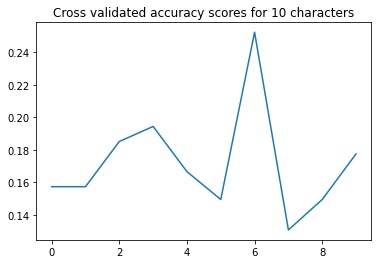

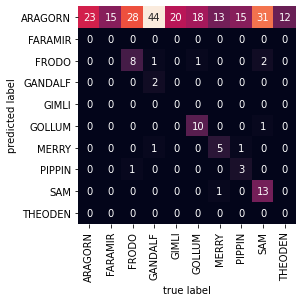

Accuracy score: 0.17843866171003717
Execution time: 8.121275186538696 seconds 


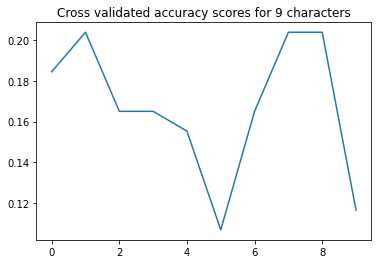

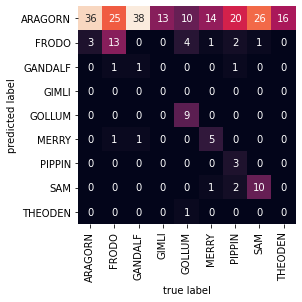

Accuracy score: 0.18604651162790697
Execution time: 8.148866891860962 seconds 


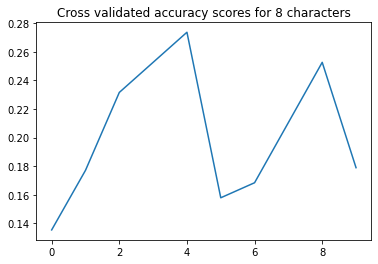

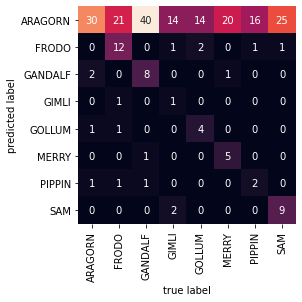

Accuracy score: 0.18907563025210083
Execution time: 6.391361951828003 seconds 


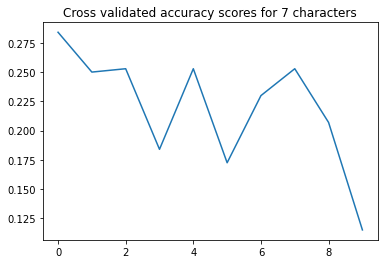

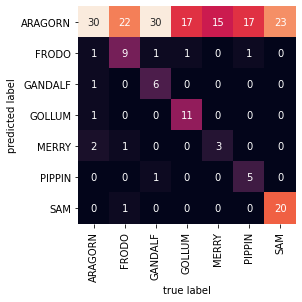

Accuracy score: 0.319634703196347
Execution time: 5.454987049102783 seconds 


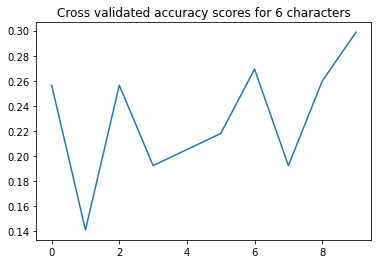

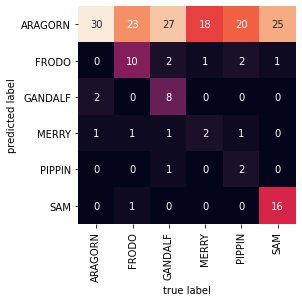

Accuracy score: 0.2923076923076923
Execution time: 4.3854758739471436 seconds 


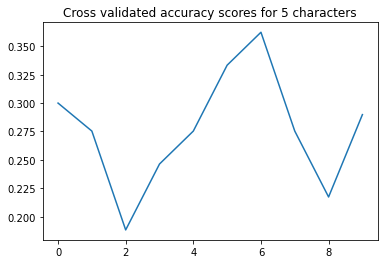

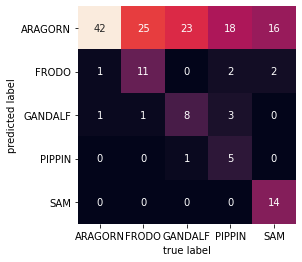

Accuracy score: 0.31213872832369943
Execution time: 3.5361201763153076 seconds 


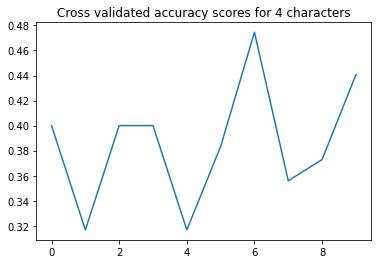

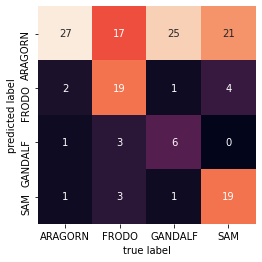

Accuracy score: 0.41333333333333333
Execution time: 2.982194185256958 seconds 


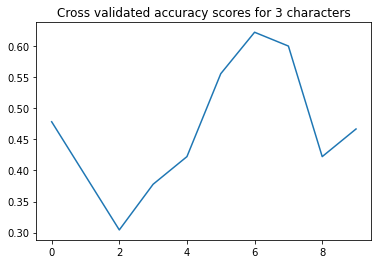

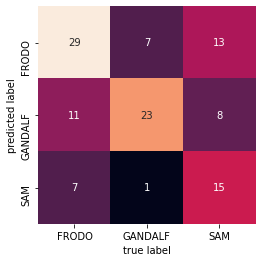

Accuracy score: 0.4649122807017544
Execution time: 1.4221928119659424 seconds 


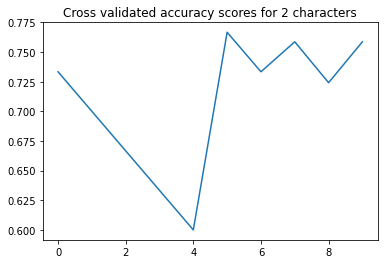

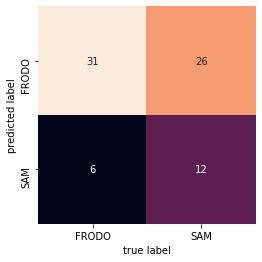

Accuracy score: 0.5733333333333334
Execution time: 3.235245943069458 seconds 


In [8]:
for num_chars in range(10,1,-1):
    # Preprocess and generate train-test data
    df.dropna(inplace=True)
    df = df[df.char.isin(top10_chars[:num_chars])]
    X = df.dialog.to_list()
    tf_idf_vect = TfidfVectorizer()
    X = tf_idf_vect.fit_transform(X)
    y = df['char']
    y = pd.get_dummies(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8,random_state=1)

    # Get best parameters for random forest model and then create it
    best_params = get_best_params(X_train, y_train)
    best_rf = RandomForestClassifier(oob_score=best_params['oob_score'], 
                                 n_estimators=best_params['n_estimators'], 
                                 min_samples_split=best_params['min_samples_split'], 
                                 min_samples_leaf=best_params['min_samples_leaf'],
                                 max_features=best_params['max_features'],
                                 max_depth=best_params['max_depth'],
                                 class_weight=best_params['class_weight']
                                )
    # Show cross validated accuracy scores
    get_cv_plot(best_rf, X_train, y_train, num_chars)

    # Get statistics including confusion matrix, accuracy score, and execution time 
    best_model_stats(best_rf, X_train, X_test, y_train, y_test)



